In [18]:
using Convex
using PyPlot
using ECOS
set_default_solver(ECOSSolver(verbose=0))

ECOS.ECOSSolver(Any[(:verbose, 0)])

In [2]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# OLS is invariant

In [19]:
d = 10
n = 20
w = randn(d)
X, y = generate_data(n, w);

In [20]:
w = X\y
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = Xscale\yscale
@show Xscale*wscale / 5;

X * w = [-2.4134, -2.40803, 1.57924, -2.21729, 3.9604, 3.92807, -0.82857, 2.82459, 4.23496, 1.47688, 4.75909, 3.36584, -0.737745, -3.89255, 2.07233, 4.28811, 0.476134, 0.741865, -3.25793, -1.01576]
(Xscale * wscale) / 5 = [-2.4134, -2.40803, 1.57924, -2.21729, 3.9604, 3.92807, -0.82857, 2.82459, 4.23496, 1.47688, 4.75909, 3.36584, -0.737745, -3.89255, 2.07233, 4.28811, 0.476134, 0.741865, -3.25793, -1.01576]


# ridge regression is not scaling invariant

In [5]:
size(X'*X + eye(d))

(10, 10)

In [6]:
w = (X'*X + eye(d)) \ (X'*y)
@show X*w

yscale = 5*y
Xscale = 3*X
wscale = (Xscale'*Xscale + eye(d)) \ (Xscale'*yscale)
@show Xscale * wscale / 5;

X * w = [-4.25954, 6.52676, 5.48567, 3.49449, -1.55858, 6.4709, 0.499291, -2.72747, 9.24994, 2.4029, 5.35288, 4.61198, 3.92006, -0.343497, 1.77049, -0.761807, 4.99874, -4.57552, -4.67206, 3.85784]
(Xscale * wscale) / 5 = [-4.48514, 6.65091, 5.81355, 3.71159, -1.45875, 6.6764, 0.74934, -2.81532, 9.62169, 2.51536, 5.58495, 4.90073, 4.03773, -0.388096, 1.72269, -0.880624, 5.08973, -4.61459, -4.9805, 3.92692]


In [7]:
# standardize
function standardize(X,y)
    X_standard = X .- mean(X,1)
    X_standard = X_standard * diagm(1./vec(std(X,1)))
    
    y_standard = y - mean(y)
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

Xs, ys = standardize(X,y)
w = (Xs'*Xs + eye(d)) \ (Xs'*ys)
@show Xs*w

yscale = 5*y + 3000
Xscale = 3*X + 200

Xss, yss = standardize(Xscale,yscale)
wscale = (Xss'*Xss + eye(d)) \ (Xss'*yss)
@show Xss*wscale;

Xs * w = [-1.45538, 1.03927, 0.824513, 0.358049, -0.807915, 1.02643, -0.334133, -1.10989, 1.69367, 0.0814538, 0.764786, 0.635467, 0.468391, -0.551412, -0.0375835, -0.655241, 0.692295, -1.52549, -1.53834, 0.431052]
Xss * wscale = [-1.45538, 1.03927, 0.824513, 0.358049, -0.807915, 1.02643, -0.334133, -1.10989, 1.69367, 0.0814538, 0.764786, 0.635467, 0.468391, -0.551412, -0.0375835, -0.655241, 0.692295, -1.52549, -1.53834, 0.431052]


# let's compare different kinds of regularized regression

In [22]:
function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

ridge_regression (generic function with 1 method)

In [23]:
function lasso(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

lasso (generic function with 1 method)

In [24]:
function nnls(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y), w>=0)
    solve!(p)
    return w.value
end

nnls (generic function with 1 method)

In [26]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

In [32]:
w_sparse

30-element SparseVector{Float64,Int64} with 17 stored entries:
  [1 ]  =  -0.558598
  [2 ]  =  1.23467
  [3 ]  =  -0.165296
  [7 ]  =  -1.52902
  [10]  =  0.548392
  [11]  =  -0.816845
  [13]  =  -1.52673
  [16]  =  -0.319458
  [17]  =  -0.516988
  [18]  =  -1.81548
  [21]  =  0.194316
  [25]  =  2.37425
  [26]  =  0.562926
  [27]  =  -1.56176
  [28]  =  -1.59356
  [29]  =  -0.565458
  [30]  =  -0.483649

In [33]:
# find best model for each type of data
w = w_sparse

X,y = generate_data(30, w)
w_ridge = ridge_regression(X,y)
w_lasso = lasso(X,y; λ=1)
w_nonneg = nnls(X,y);

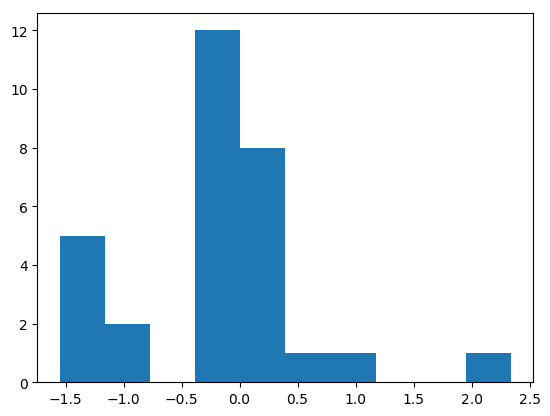

([5.0, 2.0, 0.0, 12.0, 8.0, 1.0, 1.0, 0.0, 0.0, 1.0], [-1.54756, -1.15895, -0.77033, -0.381714, 0.00690215, 0.395518, 0.784134, 1.17275, 1.56137, 1.94998, 2.3386], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x13147a810>, PyObject <matplotlib.patches.Rectangle object at 0x13147ae90>, PyObject <matplotlib.patches.Rectangle object at 0x131485550>, PyObject <matplotlib.patches.Rectangle object at 0x131485bd0>, PyObject <matplotlib.patches.Rectangle object at 0x131495290>, PyObject <matplotlib.patches.Rectangle object at 0x131495910>, PyObject <matplotlib.patches.Rectangle object at 0x131495f90>, PyObject <matplotlib.patches.Rectangle object at 0x1314a2650>, PyObject <matplotlib.patches.Rectangle object at 0x1314a2cd0>, PyObject <matplotlib.patches.Rectangle object at 0x1314af390>])

In [34]:
plt[:hist](w_ridge)

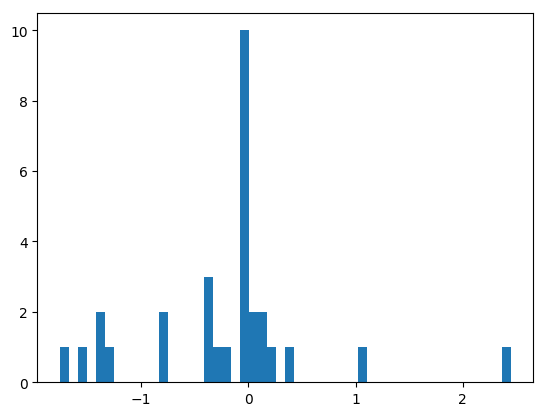

([1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [-1.75326, -1.66925, -1.58524, -1.50124, -1.41723, -1.33322, -1.24921, -1.1652, -1.08119, -0.997185  …  1.69108, 1.77509, 1.8591, 1.9431, 2.02711, 2.11112, 2.19513, 2.27914, 2.36315, 2.44715], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x13165a050>, PyObject <matplotlib.patches.Rectangle object at 0x13165a6d0>, PyObject <matplotlib.patches.Rectangle object at 0x13165ad50>, PyObject <matplotlib.patches.Rectangle object at 0x131666410>, PyObject <matplotlib.patches.Rectangle object at 0x131666a90>, PyObject <matplotlib.patches.Rectangle object at 0x131666f90>, PyObject <matplotlib.patches.Rectangle object at 0x1316747d0>, PyObject <matplotlib.patches.Rectangle object at 0x131674e50>, PyObject <matplotlib.patches.Rectangle object at 0x131680510>, PyObject <matplotlib.patches.Rectangle object at 0x131680b90>  …  PyObject <matplotlib.patches.Rectangle object at 0x1

In [35]:
plt[:hist](w_lasso, bins=50)

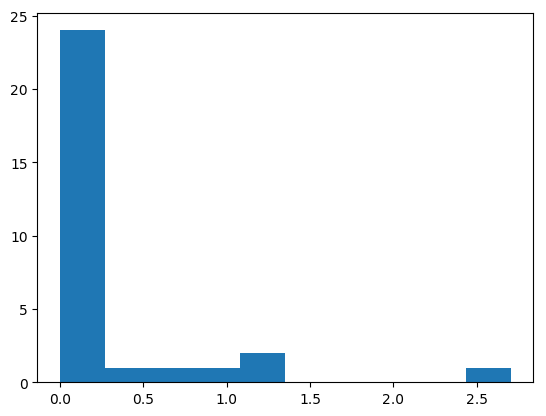

([24.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0], [-1.10638e-9, 0.270468, 0.540935, 0.811403, 1.08187, 1.35234, 1.62281, 1.89327, 2.16374, 2.43421, 2.70468], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x1318f1e10>, PyObject <matplotlib.patches.Rectangle object at 0x1318ff4d0>, PyObject <matplotlib.patches.Rectangle object at 0x1318ffb50>, PyObject <matplotlib.patches.Rectangle object at 0x13190a210>, PyObject <matplotlib.patches.Rectangle object at 0x13190a890>, PyObject <matplotlib.patches.Rectangle object at 0x13190af10>, PyObject <matplotlib.patches.Rectangle object at 0x1319185d0>, PyObject <matplotlib.patches.Rectangle object at 0x131918c50>, PyObject <matplotlib.patches.Rectangle object at 0x131926310>, PyObject <matplotlib.patches.Rectangle object at 0x131926990>])

In [36]:
plt[:hist](w_nonneg)

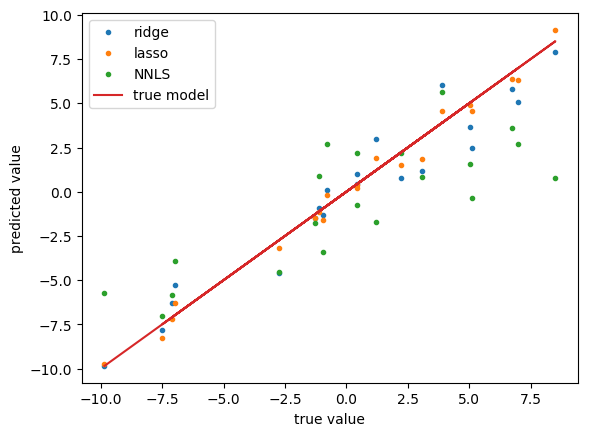

PyObject <matplotlib.text.Text object at 0x131934a10>

In [37]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

plot(ytest,Xtest*w_ridge,label="ridge",".")
plot(ytest,Xtest*w_lasso,label="lasso",".")
plot(ytest,Xtest*w_nonneg,label="NNLS",".")
plot(ytest,ytest,label="true model")
legend()
xlabel("true value")
ylabel("predicted value")

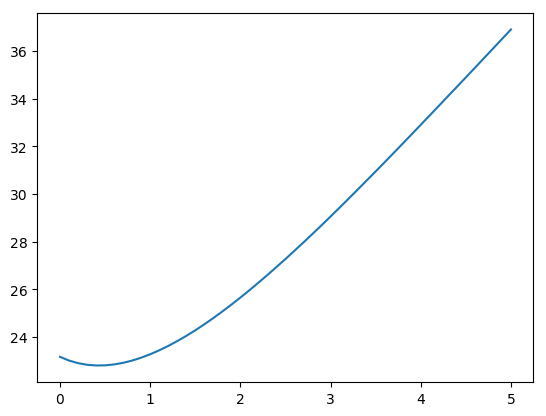

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x131cab350>

In [38]:
# cross validate over lambda

w = .5*randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

error = Float64[]
λs = 0:.1:5
for λ in λs
    w = ridge_regression(X,y; λ=λ)
    push!(error, sum((ytest - Xtest*w).^2))
end
plot(λs, error)